<a href="https://colab.research.google.com/github/adityaanand2002/Cryptocurrency-Price-Predictor/blob/main/Cryptocurrency%20Price%20Prediction%20Using%20Long-Short%20Term%20Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cryptocurrency Price Prediction Using Long-Short Term Memory:

> **Cryptocurrency** is a type of online payment that may be used to buy and sell products and services. Many businesses have created their own currencies, known as tokens, that can be exchanged for the goods or services that the business offers. Consider them to be arcade tokens or casino chips. To use the good or service, you'll need to convert actual money for cryptocurrency. is the technology that enables cryptocurrency to function. is a technology that handles and records transactions across numerous computers. The security of this technology is part of its attractiveness.


> We'll look at three of the most well-known ones in this study. As a result, this aims to do the following by employing machine learning algorithms that can uncover hidden patterns in data, integrate them, and generate considerably more accurate predictions:


*   Providing a complete examination of the many existing techniques for predicting the prices of Bitcoin, Ethereum, and (BTC, ETH, and LTC, respectively).
*   For prediction, a deep learning method called long short-term memory (LSTM) has been used.

The main goal is to develop a trustworthy prediction model based on historical values that investors can trust.

The model will then help us allocate different amounts of sum(buying and selling both) to different currencies depending on the amount entered by the user.

### **Dataset used in this Project**

We are training our pricing model, using public price data of cryptocurrencies reported from Jan 1st, 2018 to Dec 31, 2020 downloaded from Yahoo Finance. For testing our model, we use the price data of cryptocurrencies from Jan 1st 2021 to present date. We use the model to predict the crytocurrency prices for this period and compare it to the actual prices to check the efficiency of this model in predicting the prices.



### **Model used for prediction**

We are using a multilayer RNN Long Term Short Term Memory (LSTM) model having 3 LSTM layers with each layer followed by a dropout layer (with 20% dropout frequency) and at last have used a Dense layer to produce the predicted price.

In RNN, the information goes through a cycle. When making a decision, it considers the current input and also what it has learned from the inputs it has received previously.

### **Problems with the approach**

The RNN-LSTM model that we have used to predict the prices of crypto currency is very accurate on the test data, however, it fails to predict the prices very accurately for the long term. We observed that the model can be used for predicting prices only for the next 5-7 days without significant loss in accuracy. That is why we have only used the model to predict the prices for the next 7 days.

## Implementation

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score

In [11]:
# The crypto currencies we will study
crypto_currency1 = 'BTC'
crypto_currency2 = 'ETH'
crypto_currency3 = 'LTC'

# The currency we will look at the cyptocurrency against (So for Bitcoin,  we will say 1 BTC = Rs. XXXXXXXX)
against_currency = 'INR'

acc = []

In [12]:
def create_and_fit__model(x_train, y_train):
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train, y_train, epochs=25, batch_size=32)

  return model


In [13]:
def prediction_function(crypto_currency):
  # The dataset should be read/downloaded from the 1st of Jan, 2018
  start_date = dt.datetime(2018, 1, 1)
  # The dateset should be read/download till today
  end_date = dt.datetime.now()

  df = yf.download(f'{crypto_currency}-{against_currency}', start=start_date, end=end_date)

  # Printing the first few entries of the dataset
  print("\n\nThe head of the dataframe of {}: \n\n".format(crypto_currency))
  print(df.head())

  print("\n\n Description of the dataset of {}: \n\n".format(crypto_currency))
  print(df.describe())

  # Pre-Processing

  # Scaling the data using the Min Max Scaling between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))

  df_scaled = scaler.fit_transform(df[['Close', 'Volume']].values.reshape(-1, 2))

  # Looks back on 60 days of data to predict the values of 61st day
  lookback = 60


  x_train, y_train, vol, = [], [], []

  # Filling up the x_train and y_train with the scaled data
  for i in range(lookback, len(df_scaled)):

      # Finding the consolidated Volume for the past lookback days
      com_vol = 0
      for j in range(i - lookback, i):
          com_vol += df_scaled[j, 1]

      # Re-Scaling it to the range [0, 1]
      com_vol = com_vol / 60
      vol.append(com_vol)

      # The value f Closing Price for the last 'lookback' days should be used to predict the value of today, hence all Closing Price from i - lookback to i (excluded) are the features
      x_train.append(df_scaled[i - lookback: i, 0])

      # The value of Closing price at i is the the required output/label
      y_train.append(df_scaled[i, 0])


  # Converting the data set we have created into a numpy array
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  vol = np.array(vol)

  # Adding the consolidated volume to the training data
  #x_train = np.column_stack((x_train, vol))

  print("\n\n The number of samples in our training data = " + str(len(x_train)) + "\n\n")

    # *********************** Testing Data **************************

  # Start Date of Testing data
  test_start = dt.datetime(2021, 1, 1)
  # End Date of Testing data
  test_end = dt.datetime.now()


  # Downloading the data from Yahoo Finance API
  df_test = yf.download(f'{crypto_currency}-{against_currency}', start=test_start, end=test_end)

  actual_prices = df_test['Close'].values

  # Creating a combined (Test + Train data set)
  df_total = pd.concat((df['Close'], df_test['Close']), axis=0)


  # The inputs to the model for testing will be the test data set - lookback days (as we don't have past data for the last 'lookback' days)
  model_inputs = df_total[len(df_total) - len(df_test) - lookback:].values
  model_inputs = model_inputs.reshape(-1, 1)
  # The test data has not been scaled, so scaling the test data to the range (0, 1) using the MinMaxScaler
  model_inputs = scaler.fit_transform(model_inputs)


  x_test, y_test = [], []

  # Creating an 2D array of of our data where each data item has 'lookback' number of rows signifying the Closing Price of past 'lookback' days
  for i in range(lookback, len(model_inputs)):
      x_test.append(model_inputs[i - lookback: i, 0])
      y_test.append(model_inputs[i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  print("\n\n The number of samples in our testing data = " + str(len(x_test)) + "\n\n")
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # Creating the model
  model = create_and_fit__model(x_train, y_train)

  # Predicting the value and inverting the scaling
  prediction_prices = model.predict(x_test)
  prediction_prices = scaler.inverse_transform(prediction_prices)

  acc.append(r2_score(actual_prices, prediction_prices))

  # Plotting the training, test and prediction data
  plt.plot(actual_prices, color='black', label='Actual Prices')
  plt.plot(prediction_prices, color='green', label='Predicted Prices')
  plt.title("{} Price Prediction".format(crypto_currency))
  plt.xlabel("Time")
  plt.ylabel("Price")
  plt.legend(loc='upper left')
  plt.show()

  # Predict next day

  real_data = [model_inputs[len(model_inputs) - lookback:len(model_inputs) + 1, 0]]
  real_data = np.array(real_data)

  prediction = []
  #real_data[0].shape

  for i in range(7):
      rd = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
      t = model.predict(rd)
      price = scaler.inverse_transform(t)
      prediction.append(price[0][0])
      n_real_data = []
      for i in range(1, len(real_data[0])):
          n_real_data.append([real_data[0][i]])
      n_real_data.append(t[0])
      n_real_data = np.array(n_real_data)
      n_real_data = np.transpose(n_real_data)
      real_data = n_real_data

  # prediction
  prediction = np.array(prediction)
  prediction = np.reshape(prediction, (len(prediction), 1))

  final_prediction_prices = prediction_prices
  final_prediction_prices = np.row_stack((final_prediction_prices, prediction))

  plt.plot(actual_prices, color='black', label='Actual Prices')
  plt.plot(final_prediction_prices, color='green', label='Predicted Prices')
  plt.title("{} Price Prediction with 7 days forecast".format(crypto_currency))
  plt.xlabel("Time")
  plt.ylabel("Price")
  plt.legend(loc='upper left')
  plt.show()

  price_today = actual_prices[len(actual_prices)-1]
  pred_price_today = prediction_prices[len(prediction_prices)-1][0]

  max_price = prediction[0][0]
  min_price = prediction[0][0]
  for i in range(len(prediction)):
    max_price = max(max_price, prediction[i][0])
    min_price = min(min_price, prediction[i][0])

  upside = (((max_price - pred_price_today)*100)/pred_price_today)
  downside = (((min_price - pred_price_today)*100)/pred_price_today)

  return [upside, downside]

[*********************100%***********************]  1 of 1 completed


The head of the dataframe of BTC: 


                   Open          High          Low         Close  \
Date                                                               
2018-01-01  900781.7500  9.007818e+05  837625.5625  8.696222e+05   
2018-01-02  867571.8750  9.799599e+05  838620.0000  9.506142e+05   
2018-01-03  950366.8125  9.896904e+05  942885.5000  9.652635e+05   
2018-01-04  969689.4375  9.978183e+05  920925.3125  9.889113e+05   
2018-01-05  981177.1250  1.121270e+06  963781.5000  1.103810e+06   

               Adj Close         Volume  
Date                                     
2018-01-01  8.696222e+05   655292159999  
2018-01-02  9.506142e+05  1068916782180  
2018-01-03  9.652635e+05  1071365660160  
2018-01-04  9.889113e+05  1380945947770  
2018-01-05  1.103810e+06  1509844138230  


 Description of the dataset of BTC: 


               Open          High           Low         Close     Adj Close  \
c

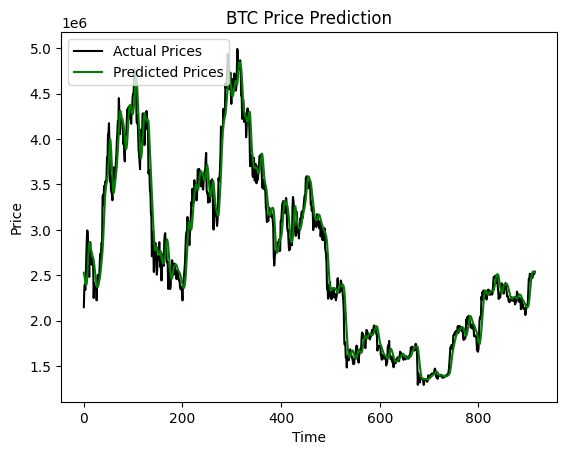

1/1 [==============================] - 0s 29ms/step


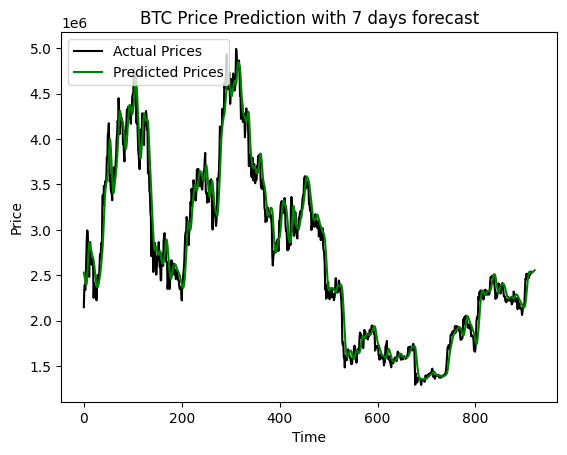

[*********************100%***********************]  1 of 1 completed


The head of the dataframe of ETH: 


                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  48239.968750  49827.601562  47362.117188  49197.914062   
2018-01-02  49179.132812  58251.800781  49179.132812  56117.968750   
2018-01-03  56216.699219  61878.910156  55161.835938  61132.718750   
2018-01-04  61068.777344  66252.843750  60014.964844  62185.550781   
2018-01-05  61857.671875  68104.453125  60564.062500  63185.605469   

               Adj Close        Volume  
Date                                    
2018-01-01  49197.914062  165285026150  
2018-01-02  56117.968750  366953542271  
2018-01-03  61132.718750  323415655935  
2018-01-04  62185.550781  412248795500  
2018-01-05  63185.605469  423243878353  


 Description of the dataset of ETH: 


                Open           High            Low          Close  \
coun

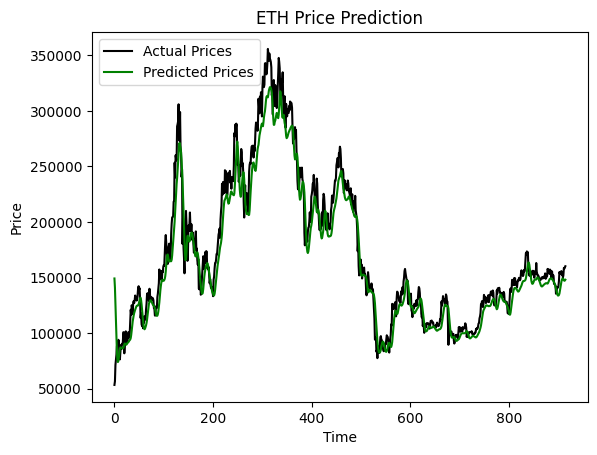

1/1 [==============================] - 0s 52ms/step


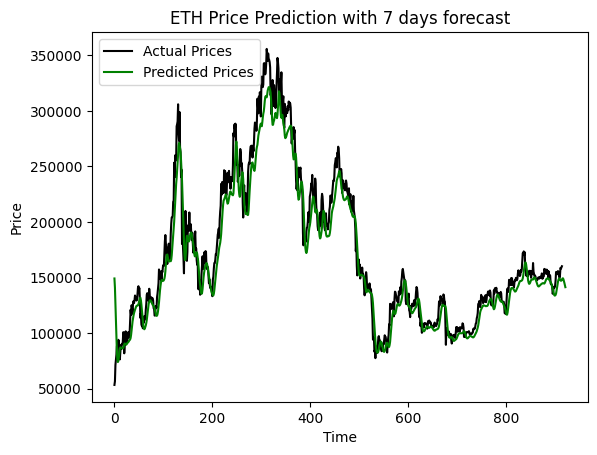

[*********************100%***********************]  1 of 1 completed


The head of the dataframe of LTC: 


                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14787.241211  15066.487305  14183.217773  14583.676758   
2018-01-02  14580.938477  16737.550781  14580.938477  16223.150391   
2018-01-03  16223.848633  16544.080078  15439.072266  15580.868164   
2018-01-04  15587.663086  15587.663086  14397.164062  15301.650391   
2018-01-05  15280.350586  16234.661133  15080.403320  15786.332031   

               Adj Close        Volume  
Date                                    
2018-01-01  14583.676758   40315317869  
2018-01-02  16223.150391   78547924454  
2018-01-03  15580.868164  204170288128  
2018-01-04  15301.650391  220712867322  
2018-01-05  15786.332031  108332293947  


 Description of the dataset of LTC: 


               Open          High           Low         Close     Adj Clo

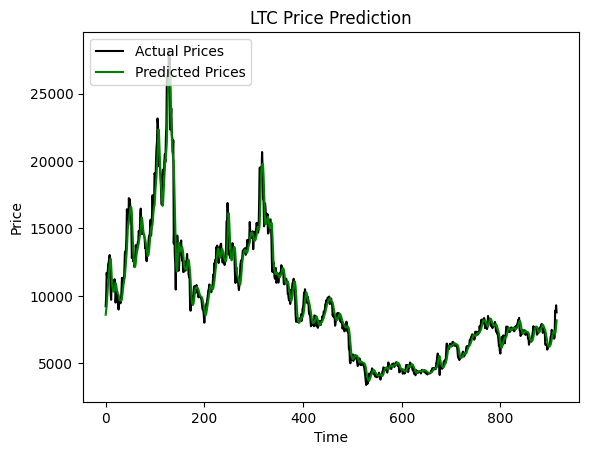

1/1 [==============================] - 0s 41ms/step


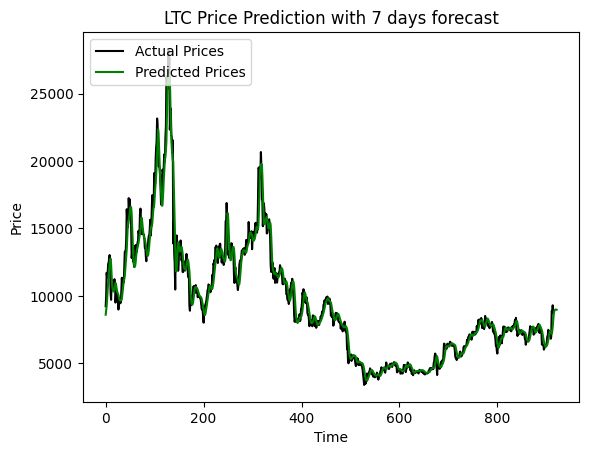

In [14]:
sides1 = prediction_function(crypto_currency1)
sides2 = prediction_function(crypto_currency2)
sides3 = prediction_function(crypto_currency3)

In [15]:
print("The R2 accuracy score for BTC = {} %".format(acc[0]*100))
print("The R2 accuracy score for ETH = {} %".format(acc[1]*100))
print("The R2 accuracy score for LTC = {} %".format(acc[2]*100))

print("Average R2 accuracy score = {} %".format((acc[0]+acc[1]+acc[2])*100/3))

The R2 accuracy score for BTC = 96.62727652197454 %
The R2 accuracy score for ETH = 93.79648651651074 %
The R2 accuracy score for LTC = 96.39660738532504 %
Average R2 accuracy score = 95.60679014127011 %


In [16]:
amount = np.float64(input("Enter the amount: "))

if sides1[0] < 0:
  sides1[0] = 0

if sides2[0] < 0:
  sides2[0] = 0

if sides3[0] < 0:
  sides3[0] = 0

if sides1[0] == 0 and sides2[0] == 0 and sides3[0] == 0:
  print("This is not the right time to invest! All the cryptocurrencies are going in loss. You might suffer a low of (upper limit): {}% !!!".format(sides1[1] + sides2[1] + sides3[1]))

else:
  BTC_share = amount*(sides1[0]/(sides1[0] + sides2[0] + sides3[0]))
  BTC_upside = (BTC_share*sides1[0])/100
  BTC_downside = (BTC_share*sides1[1])/100

  ETH_share = amount*(sides2[0]/(sides1[0] + sides2[0] + sides3[0]))
  ETH_upside = (ETH_share*sides2[0])/100
  ETH_downside = (ETH_share*sides2[1])/100

  LTC_share = amount*(sides3[0]/(sides1[0] + sides2[0] + sides3[0]))
  LTC_upside = (LTC_share*sides3[0])/100
  LTC_downside = (LTC_share*sides3[1])/100

  total_upside = BTC_upside + ETH_upside + LTC_upside
  total_downside = BTC_downside + ETH_downside + LTC_downside

  BTC_share = round(BTC_share, 2)
  ETH_share = round(ETH_share, 2)
  LTC_share = round(LTC_share, 2)

  print("You should invest\n {} {} in {}\n {} {} in {}\n {} {} in {} \nFor an upside of {}% and downside of {}% !".format(
                                                                        against_currency, BTC_share, crypto_currency1,
                                                                        against_currency, ETH_share, crypto_currency2,
                                                                        against_currency, LTC_share, crypto_currency3,
                                                                        round((total_upside/amount) * 100, 2),
                                                                        round((total_downside/amount) * 100, 2)))

Enter the amount: 10000
You should invest
 INR 913.48 in BTC
 INR 738.79 in ETH
 INR 8347.73 in LTC 
For an upside of 8.31% and downside of 3.89% !
